In [1]:
import numpy as np
import tensorflow as tf
import helpful_functions as hf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ---only for cluster--- #
import tensorflow as tf

phys_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(phys_devices[0], True)
except IndexError:
    pass

In [2]:
# -----encoder 3Input 10x10x16 image 64x64 pixel----- #
#encoder
encoder_inputs = keras.Input(shape=(64, 64, 1), name="img_input")
x = layers.Conv2D(8, 3, activation="relu")(encoder_inputs)
x = layers.Conv2D(16, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(16, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(16, 3, activation="relu")(block_2_output)
block_3_output = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(16, 3, activation="relu", padding="same")(block_3_output)
x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
block_4_output = layers.add([x, block_3_output])

x  = layers.Conv2D(16, 3, activation="relu")(block_4_output)
encoder_outputs= layers.Conv2D(16, 3, activation="relu")(x)

encoder = keras.Model(encoder_inputs, encoder_outputs, name="encoder")
#encoder.summary()

#decoder
decoder_inputs = keras.Input(shape=(10, 10, 16), name="decoder_input")
x = layers.Conv2DTranspose(16, 3, activation="relu")(decoder_inputs)
block_5_output = layers.Conv2DTranspose(16, 3, activation="relu")(x)

x = layers.Conv2DTranspose(16, 3, activation="relu", padding="same")(block_5_output)
x = layers.Conv2DTranspose(16, 3, activation="relu", padding="same")(x)
block_6_output = layers.add([x, block_5_output])

x = layers.UpSampling2D(2)(block_6_output)
block_7_output = layers.Conv2DTranspose(16, 3, activation="relu")(x)

x = layers.Conv2DTranspose(16, 3, activation="relu", padding="same")(block_7_output)
x = layers.Conv2DTranspose(16, 3, activation="relu", padding="same")(x)
block_8_output = layers.add([x, block_7_output])

x = layers.UpSampling2D(2)(block_8_output)
x = layers.Conv2DTranspose(8, 3, activation="relu")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="relu")(x)

decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
#decoder.summary()

# bild autoencoder
autoencoder_input1 = keras.Input(shape=(64, 64, 1), name="input_img1")
autoencoder_input2 = keras.Input(shape=(64, 64, 1), name="input_img2")
autoencoder_input3 = keras.Input(shape=(64, 64, 1), name="input_img3")

encoded_img1 = encoder(autoencoder_input1)
encoded_img2 = encoder(autoencoder_input2)
encoded_img3 = encoder(autoencoder_input3)

encoded_img4 = layers.add([encoded_img1,encoded_img2,encoded_img3])
decoded_img1 = decoder(encoded_img1)
decoded_img2 = decoder(encoded_img2)
decoded_img3 = decoder(encoded_img3)
decoded_img4 = decoder(encoded_img4)

autoencoder = keras.Model(inputs=[autoencoder_input1,autoencoder_input2,autoencoder_input3], outputs=[decoded_img1,decoded_img2,decoded_img3,decoded_img4], name="autoencoder")
autoencoder.summary()

2023-01-30 16:04:13.429620: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-30 16:04:13.430200: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2
Model: "autoencoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img1 (InputLayer)        [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 input_img2 (InputLayer)        [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 input_img3 (InputLayer)        [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 encoder (Functional)           (None, 10, 10, 16)   17488       ['input_img1[0][0]',             
                                                          

keras.utils.plot_model(decoder, show_shapes=True)

In [3]:
# load data_set
data_set = hf.load_dataset_npz('data_set/random_img_5_14_64pix_4ob.npz')
data_set = data_set.astype('float32')
x_train = data_set[:8000, :3]
y_train = data_set[:8000]
x_test = data_set[8000:, :3]
y_test = data_set[8000:]
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(8000, 3, 64, 64, 1)
(8000, 4, 64, 64, 1)
(2000, 3, 64, 64, 1)
(2000, 4, 64, 64, 1)


In [6]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

monitor = EarlyStopping(monitor='decoder_3_loss', min_delta=1e-5, patience=5,
                        verbose=1, mode='auto', restore_best_weights=True)
history = autoencoder.fit([x_train[:,0],x_train[:,1],x_train[:,2]], [y_train[:,0],y_train[:,1],y_train[:,2],y_train[:,3]], epochs=1,
                          validation_data=((x_test[:,0],x_test[:,1],x_test[:,2]), (y_test[:, 0],y_test[:, 1],y_test[:, 2],y_test[:,3])),
                          shuffle=True, batch_size=800, callbacks=[monitor])

2023-01-30 16:06:20.211729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 0.2830 - decoder_loss: 0.0470 - decoder_1_loss: 0.0470 - decoder_2_loss: 0.0475 - decoder_3_loss: 0.1415

2023-01-30 16:06:48.731649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 33s 3s/step - loss: 0.2830 - decoder_loss: 0.0470 - decoder_1_loss: 0.0470 - decoder_2_loss: 0.0475 - decoder_3_loss: 0.1415 - val_loss: 0.2828 - val_decoder_loss: 0.0478 - val_decoder_1_loss: 0.0464 - val_decoder_2_loss: 0.0472 - val_decoder_3_loss: 0.1414


In [5]:
# save the trained model
autoencoder.save('saved_model/3Inputs_(10x10x16)_64pix')
encoder.save('saved_model/encoder_(10x10x16)_64pix')
decoder.save('saved_model/decoder_(10x10x16)_64pix')

INFO:tensorflow:Assets written to: saved_model/3Inputs_(10x10x16)_64pix/assets


INFO:tensorflow:Assets written to: saved_model/3Inputs_(10x10x16)_64pix/assets


INFO:tensorflow:Assets written to: saved_model/encoder_(10x10x16)_64pix/assets


INFO:tensorflow:Assets written to: saved_model/encoder_(10x10x16)_64pix/assets


INFO:tensorflow:Assets written to: saved_model/decoder_(10x10x16)_64pix/assets


INFO:tensorflow:Assets written to: saved_model/decoder_(10x10x16)_64pix/assets


In [20]:
# make predictions
predictions = autoencoder.predict([x_test[:,0],x_test[:,1],x_test[:,2]])
np.shape(predictions)

63/63 [==============================] - 2s 26ms/step


(4, 2000, 64, 64, 1)

In [26]:
# calculate the mse and ssim
mse = tf.keras.losses.MeanSquaredError()
print(f"mse is: {mse(y_test[:,3], predictions[3]).numpy()}")
ssim = tf.image.ssim(y_test[:,3], predictions[3],max_val=1.0)
ssim_mean = np.mean(ssim)
print(f"ssim is for sample {12}: {ssim[12].numpy()}")
print(f"mean of ssim is: {ssim_mean}")

mse is: 0.0018233569571748376
ssim is for sample 12: 0.9723752737045288
mean of ssim is: 0.9661873579025269


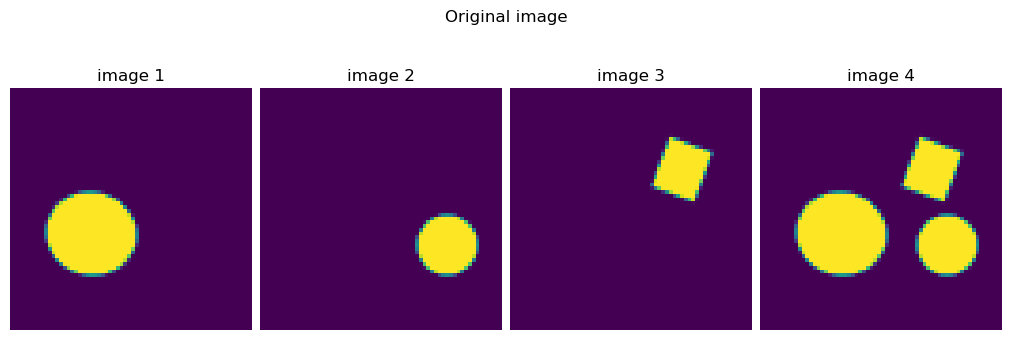

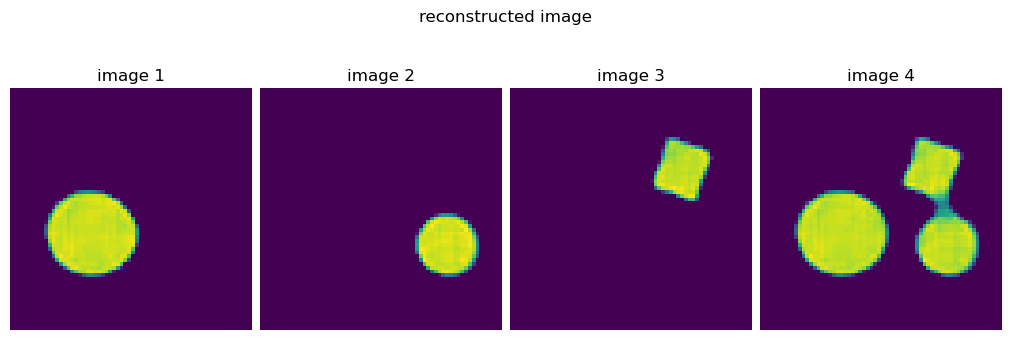

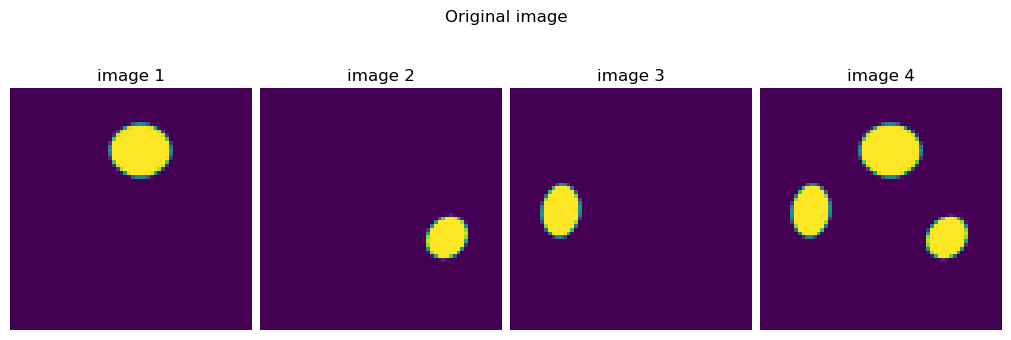

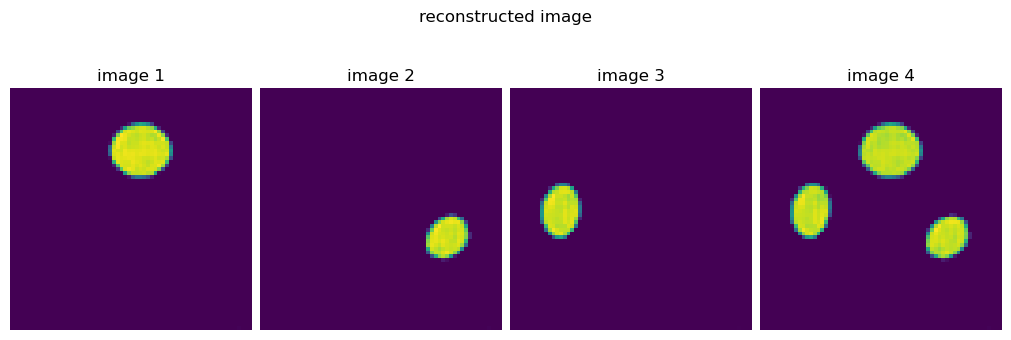

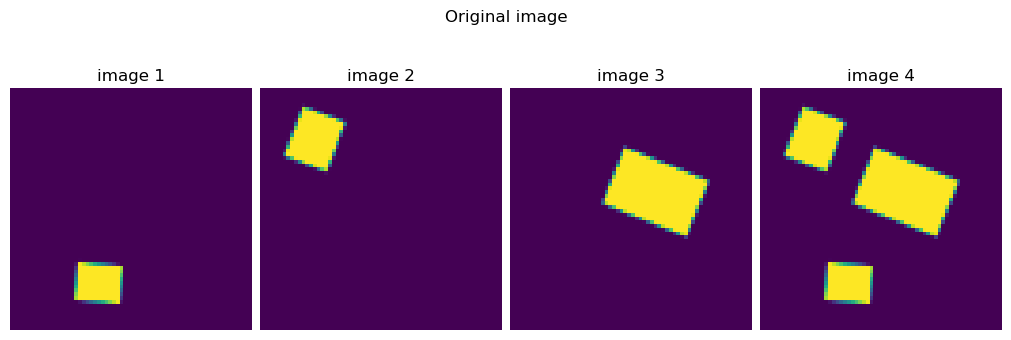

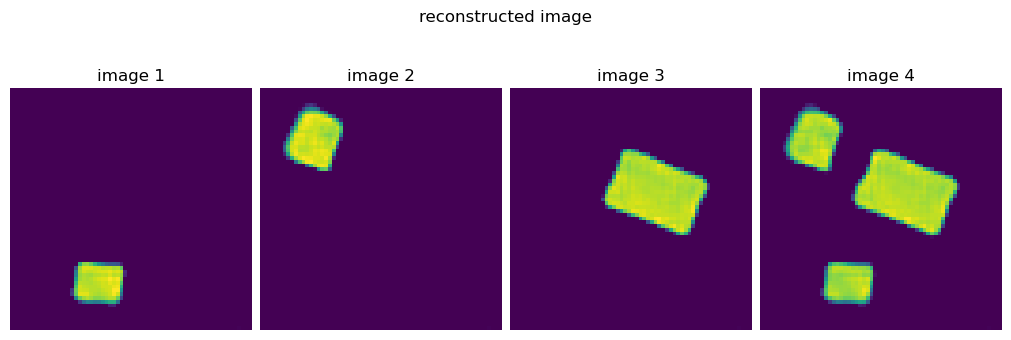

In [13]:
# visualization of the predictions
hf.show_image(sample_num=12, img_data1=data_set,img_data2=predictions)
for i in range(2):
    hf.show_image(sample_num=i+1, img_data1=data_set,img_data2=predictions)

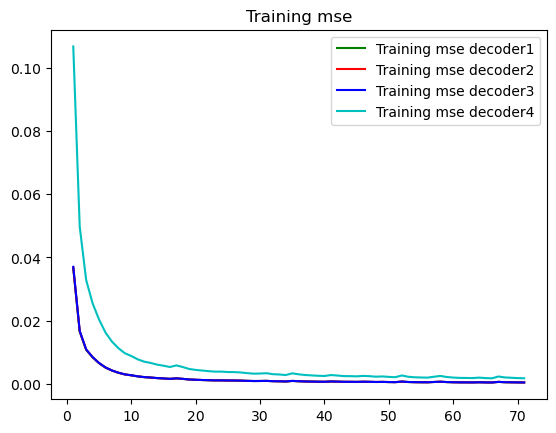

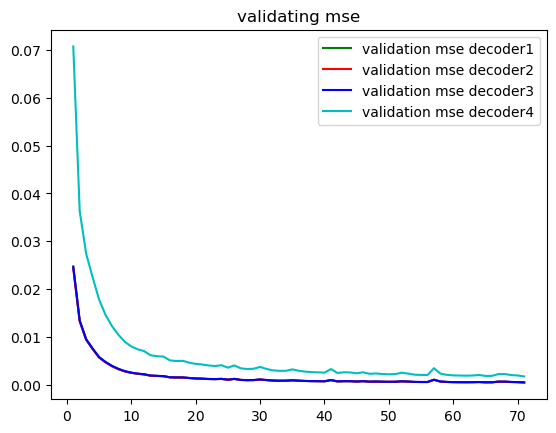

<Figure size 640x480 with 0 Axes>

In [28]:
# Visualization of the training loss
# plot training losses and validating losses
mse1= history.history['decoder_mean_squared_error']
mse2= history.history['decoder_1_mean_squared_error']
mse3 = history.history['decoder_2_mean_squared_error']
mse4 = history.history['decoder_3_mean_squared_error']

var_mse1 = history.history['val_decoder_mean_squared_error']
var_mse2 = history.history['val_decoder_1_mean_squared_error']
var_mse3 = history.history['val_decoder_2_mean_squared_error']
var_mse4 = history.history['val_decoder_3_mean_squared_error']
#loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs = range(1, len(mse1) + 1)

plt.plot(epochs, mse1, 'g', label='Training mse decoder1')
plt.plot(epochs, mse2, 'r', label='Training mse decoder2')
plt.plot(epochs, mse3, 'b', label='Training mse decoder3')
plt.plot(epochs, mse4, 'c', label='Training mse decoder4')


plt.title('Training mse')
plt.legend()
plt.figure()

plt.plot(epochs, var_mse1, 'g', label='validation mse decoder1')
plt.plot(epochs, var_mse2, 'r', label='validation mse decoder2')
plt.plot(epochs, var_mse3, 'b', label='validation mse decoder3')
plt.plot(epochs, var_mse4, 'c', label='validation mse decoder4')
#plt.plot(epochs, loss, 'g', label='Training loss')
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('validating mse')
plt.legend()
plt.figure()
plt.show()